In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Parametros por defecto de los graficos
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']=1.5
dark_style={
    'figure.facecolor': '#212946',
    'axes.facecolor':'#212946',
    'savefig.facecolor': '#212946',
    'axes.grid': True,
    'axes.grid.which':'both',
    'grid.color':'#2A3459',
    'grid.linewidth':'1',
    'text.color':'0.9',
    'axes.labelcolor':'0.9',
    'xtick.color':'0.9',
    'ytick.color':'0.9',
    'font.size':12}
plt.rcParams.update(dark_style)

# Cargar archivo after "BigQuery" .csv
df = pd.read_csv('DF_VentasDesodorante.csv', sep=',', encoding='ISO-8859-1')
df.keys()

Index(['Unnamed: 0', 'ID_Local_CD', 'ID_producto', 'Fecha_de_la_transaccion',
       'Stock_en_unidades', 'Venta_dia_anterior_en_unidades',
       'Precio_de_venta_unitario', 'CD_que_abastece',
       'Si_sigue_el_producto_en_Rol_en_el_local', 'ID_Local_CD_1',
       'ID_producto_', 'Fecha_desde_', 'Fecha_Hasta', '__de_descuento',
       'Total_ventas_en_Unidades', 'Fecha_de_la_transaccion_1',
       'Nro__Promocion', 'Tipo_promocion', 'Nivel_de_Agresividad',
       'HayPromocion', 'ID_Cadena', 'Descripcion_Cadena', 'ID_Region',
       'Descripcion_Region', 'ID_Local_CD_2', 'Descripcion_Local_CD',
       'Latitud__Y_', 'Longitud__X_', 'PD', 'ID_Proveedor',
       'Razon_Social_Proveedor', 'ID_Sector', 'Descripcion_Sector',
       'ID_Seccion', 'Descripcion_Seccion', 'ID_Gran_Familia',
       'Descripcion_Gran_Familia', 'ID_Familia', 'Descripcion_Familia',
       'ID_Subfamilia', 'Descripcion_Sub_Familia', 'ID_Articulo',
       'ID_Producto_1', 'Descripcion_Articulo', 'Descripcion_Produ

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340210 entries, 0 to 7340209
Data columns (total 46 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   Unnamed: 0                               int64  
 1   ID_Local_CD                              int64  
 2   ID_producto                              int64  
 3   Fecha_de_la_transaccion                  int64  
 4   Stock_en_unidades                        int64  
 5   Venta_dia_anterior_en_unidades           int64  
 6   Precio_de_venta_unitario                 float64
 7   CD_que_abastece                          int64  
 8   Si_sigue_el_producto_en_Rol_en_el_local  object 
 9   ID_Local_CD_1                            float64
 10  ID_producto_                             float64
 11  Fecha_desde_                             float64
 12  Fecha_Hasta                              float64
 13  __de_descuento                           float64
 14  Total_ventas_en_Un

In [21]:
df.isnull().sum()

Unnamed: 0                                       0
ID_Local_CD                                      0
ID_producto                                      0
Fecha_de_la_transaccion                          0
Stock_en_unidades                                0
Venta_dia_anterior_en_unidades                   0
Precio_de_venta_unitario                         0
CD_que_abastece                                  0
Si_sigue_el_producto_en_Rol_en_el_local          0
ID_Local_CD_1                              7074960
ID_producto_                               7074960
Fecha_desde_                               7074960
Fecha_Hasta                                7074960
__de_descuento                             7074960
Total_ventas_en_Unidades                   7074960
Fecha_de_la_transaccion_1                  7074960
Nro__Promocion                             7074960
Tipo_promocion                             7340210
Nivel_de_Agresividad                       7340210
HayPromocion                   

In [22]:
# Drop unnecessary columns
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [23]:
# Data Transformation
# Convert date columns to datetime format and set the transaction date as index
incorrect_dates = df['Fecha_de_la_transaccion'].apply(lambda x: len(str(x)) != 8 or not str(x).isdigit())
df['Fecha_de_la_transaccion'] = pd.to_datetime(df['Fecha_de_la_transaccion'], format='%Y%m%d')
df = df.set_index('Fecha_de_la_transaccion')

# Handle missing values and sort by index
df.drop(["ID_Proveedor" ,'ID_Local_CD_1', 'Fecha_desde_','Fecha_Hasta',
         'Si_sigue_el_producto_en_Rol_en_el_local',"Razon_Social_Proveedor","ID_Sector", 
         "ID_Seccion", "Descripcion_Seccion", "ID_Gran_Familia", "Descripcion_Gran_Familia" , 
         "ID_Familia", "Descripcion_Familia", "ID_Subfamilia", "Descripcion_Sub_Familia", "ID_Articulo",
         "Descripcion_Articulo", "Descripcion_Producto", "ID_Producto_1", "ID_Regi__n", "PD", 
         "ID_Local_CD_2", "Descripcion_Region", "ID_Region", "Tipo_promocion", 
         "Nivel_de_Agresividad", "Fecha_de_la_transaccion_1", "ID_producto_"], axis=1, inplace=True)
df.dropna(subset=['Latitud__Y_', 'Venta_dia_anterior_en_unidades', 'Longitud__X_', 'ID_producto'], inplace=True)
df.sort_index(inplace=True)

# Create a new variable for sales on the same day
df['Venta_mismo_dia'] = df.groupby(['ID_Local_CD', 'ID_producto'])['Venta_dia_anterior_en_unidades'].shift(periods=1)
df['Venta_mismo_dia'].dropna(inplace=True)

# Calculate sales volume
df['Valor_venta'] = df['Precio_de_venta_unitario'] * df['Venta_mismo_dia']

# Create a new column 'year_month' to represent the year and month of the transaction
df['year_month'] = pd.DatetimeIndex(df.index).strftime('%Y-%m')

In [24]:
df.head()

,ID_Local_CD,ID_producto,Stock_en_unidades,Venta_dia_anterior_en_unidades,Precio_de_venta_unitario,CD_que_abastece,__de_descuento,Total_ventas_en_Unidades,Nro__Promocion,HayPromocion,ID_Cadena,Descripcion_Cadena,Descripcion_Local_CD,Latitud__Y_,Longitud__X_,Descripcion_Sector,Venta_mismo_dia,Valor_venta,year_month
Fecha_de_la_transaccion,,,,,,,,,,,,,,,,,,,
2016-07-15,270,427444,3,1,60.84,0,NaN,NaN,NaN,0,4,Vea,150 - Padua,-34.665727,-58.696967,Almacân,NaN,NaN,2016-07
2016-07-15,9241,447299,4,0,15.56,0,NaN,NaN,NaN,0,4,Vea,241 - Edison.,-38.046367,-57.553940,Almacân,NaN,NaN,2016-07
2016-07-15,9161,370268,8,1,20.86,0,NaN,NaN,NaN,0,2,Disco,161 - Moreno II.,-34.634367,-58.791778,NaN,NaN,NaN,2016-07
2016-07-15,9112,450347,0,0,24.32,0,NaN,NaN,NaN,0,2,Disco,112 - Banfield.,-34.738192,-58.408967,NaN,NaN,NaN,2016-07
2016-07-15,5260,342745,16,0,15.56,0,NaN,NaN,NaN,0,9,Jumbo,5260 - Jumbo Acoyte,-34.610676,-58.439326,Almacân,NaN,NaN,2016-07


#  Visualizacion de los datos

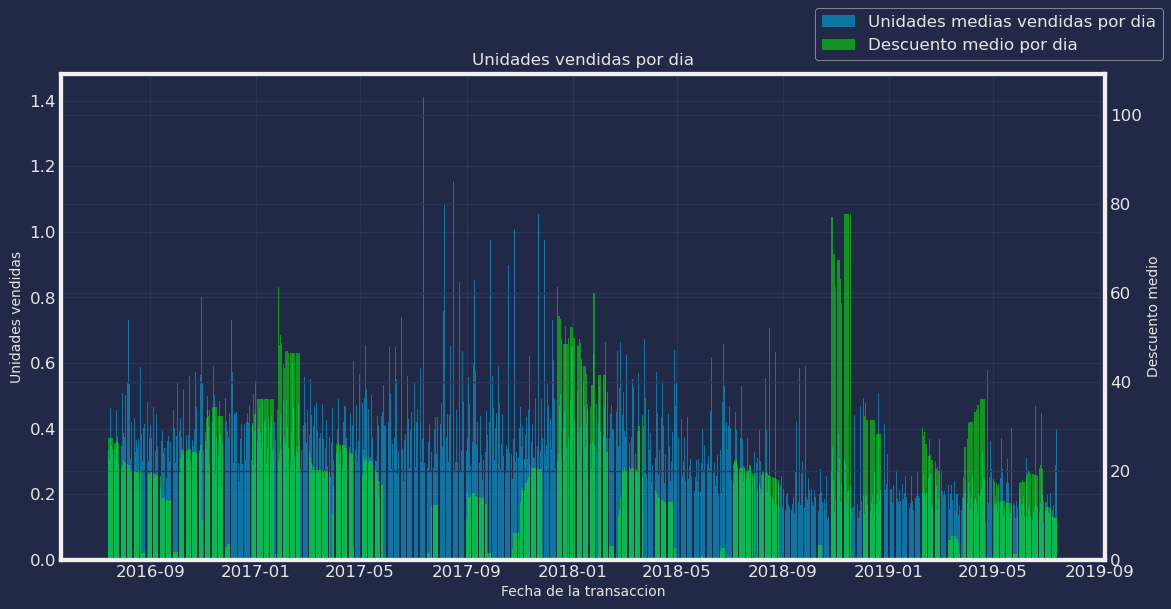

In [25]:

# Agregar columna 'year_month' con el año y mes de cada registro
df['year_month'] = pd.DatetimeIndex(df.index).strftime('%Y-%m')

# Agrupar los datos por Fecha_de_la_transaccion y calcular la media de unidades vendidas y descuentos por día
unidades_vendidas = pd.DataFrame(df.groupby('Fecha_de_la_transaccion').agg({'Venta_dia_anterior_en_unidades': 'mean', '__de_descuento': 'mean'}))

# Crear un objeto figura yn eje
fig, ax = plt.subplots(figsize=(12, 6))
ax1=ax.twinx()

# Graficar los datos
ax.bar(unidades_vendidas.index, unidades_vendidas['Venta_dia_anterior_en_unidades'],label='Unidades medias vendidas por dia',color='deepskyblue',alpha=0.5)
ax1.bar(unidades_vendidas.index, unidades_vendidas['__de_descuento'],label='Descuento medio por dia',color='lime', alpha=0.5)

# Establecer etiquetas para el eje x y el eje y
ax.set_xlabel('Fecha de la transaccion',fontsize=10)
ax.set_ylabel('Unidades vendidas',fontsize=10)
ax1.set_ylabel('Descuento medio',fontsize=10)

# Establecer título
ax.set_title('Unidades vendidas por dia', fontsize=12)

# Mostrar leyenda
fig.legend()

# Mostrar la gráfica
plt.show()

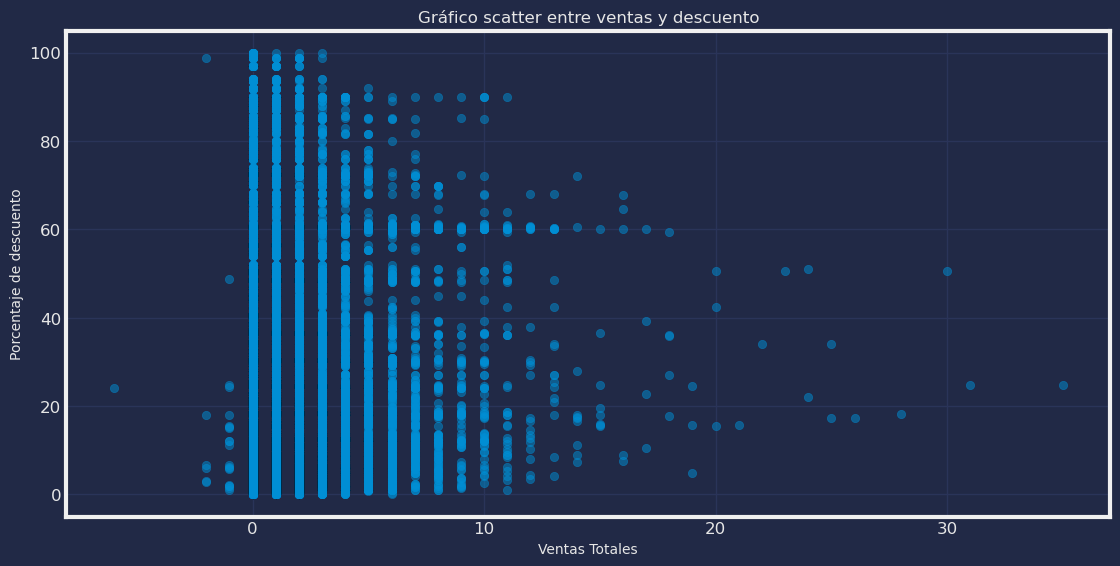

In [26]:
##Gráfico de dispersión entre ventas y descuentos".
# Se filtra el DataFrame por las columnas de interes
df_promotion = df[df['HayPromocion'] == 1]

# Se filtra las promociones menores a 100 ya que las mayores a esta no tienen sentido economico
df_promotion = df_promotion[df_promotion['__de_descuento'] <= 100]

# Grafico 'scatter' entre 'Total_ventas_en_Unidades' y "__de_descuento":
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(df_promotion['Venta_dia_anterior_en_unidades'], df_promotion['__de_descuento'], alpha=0.5)
plt.title('Gráfico scatter entre ventas y descuento', fontsize=12)
ax.set_xlabel('Ventas Totales', fontsize=10)
ax.set_ylabel('Porcentaje de descuento', fontsize=10)
plt.show()

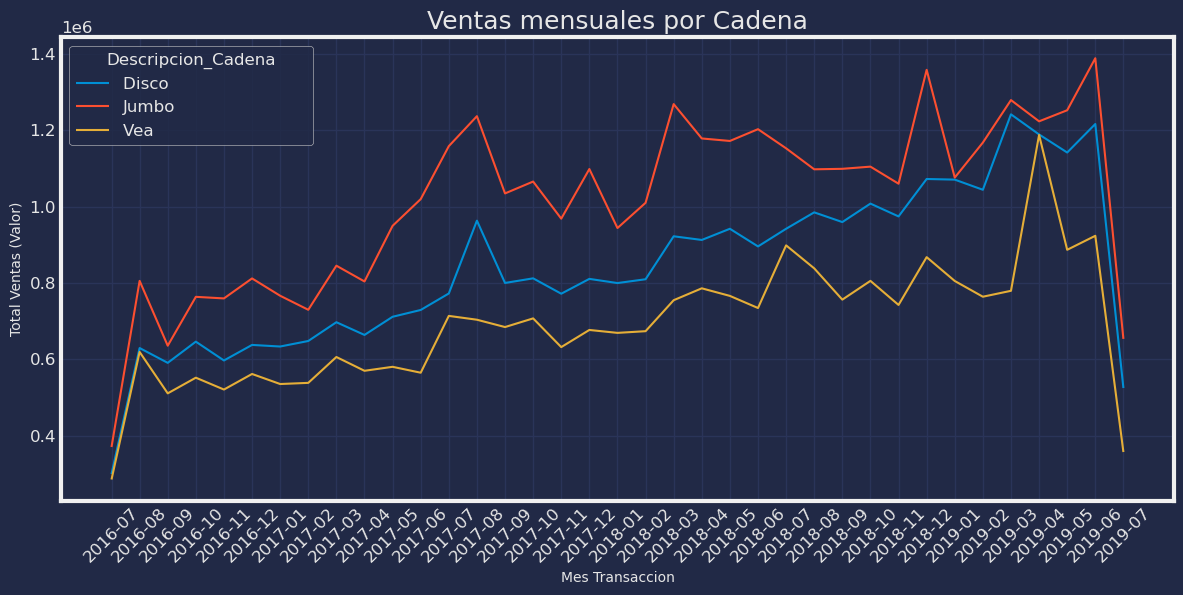

In [27]:
# Agrupar ventas mensuales por cadena
ventas_por_mes=pd.DataFrame(df.groupby(['year_month','Descripcion_Cadena'])['Valor_venta'].sum())

# Grafico ventas mensuales por cadena
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=ventas_por_mes,x='year_month',y='Valor_venta',hue='Descripcion_Cadena')

# Establecer las etiquetas de título y eje para la tramaax.set_title('Ventas del mes por Descripcion_Cadena', fontsize=15)
ax.set_xlabel('Mes Transaccion', fontsize=10)
ax.set_ylabel('Total Ventas (Valor)',fontsize=10)
ax.tick_params(axis='x', labelrotation = 45)
plt.tight_layout()

# Agregar el título del gráfico
plt.title('Ventas mensuales por Cadena', fontsize=18)

# Mostrar el gráfico
plt.show()

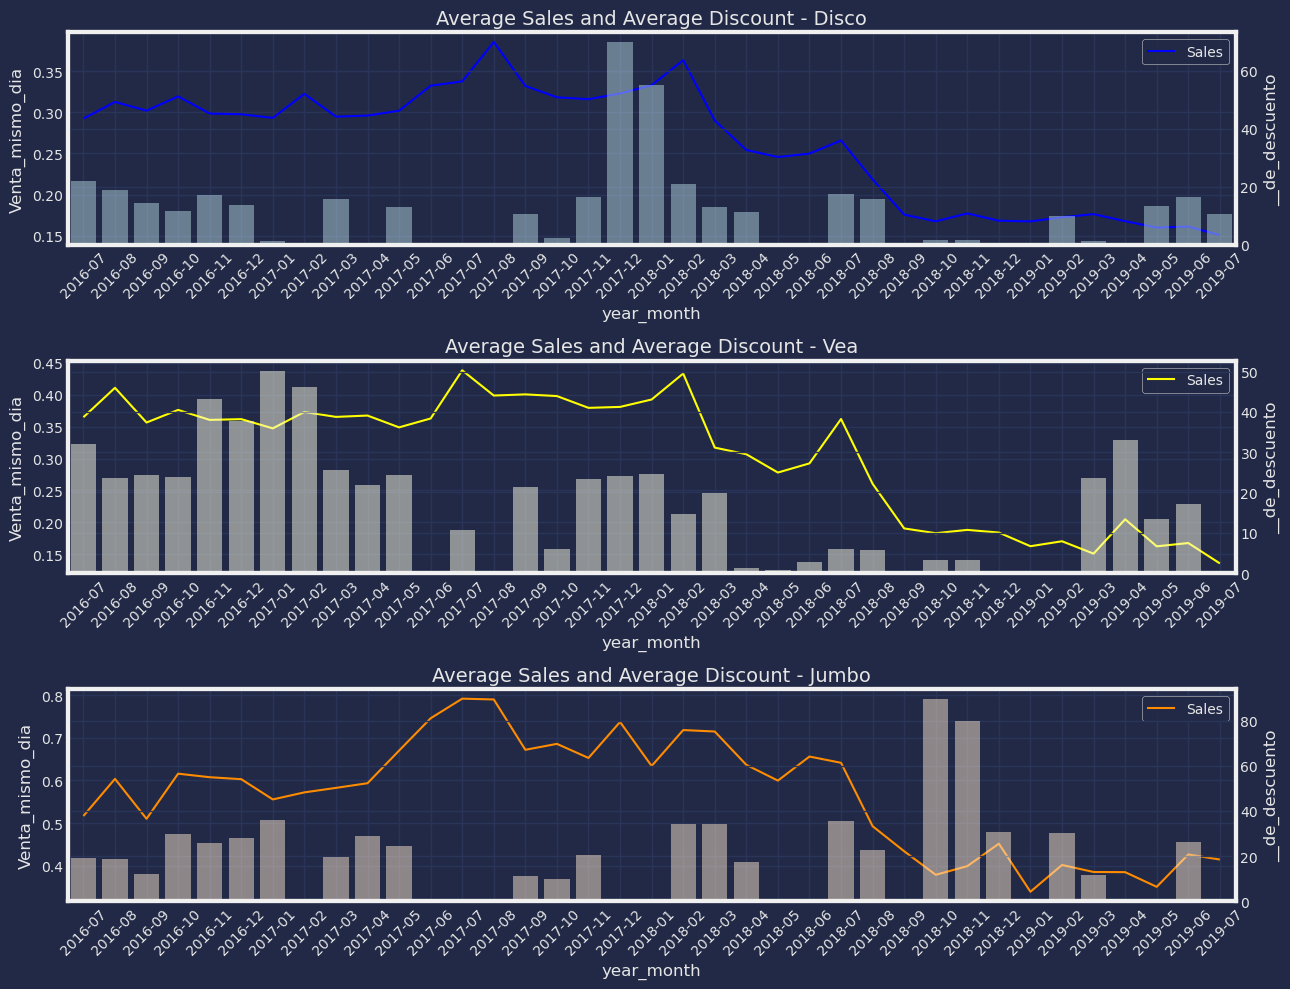

In [48]:
# Agrupar ventas mensuales por cadena
ventas_por_mes=pd.DataFrame(df.groupby(['year_month','Descripcion_Cadena']).
                            agg({'Venta_mismo_dia': 'mean',
                                 '__de_descuento': 'mean'})).reset_index()


# Create subplots
plt.rc('font', size=10)
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(13,10))
ax4=ax1.twinx()
ax5=ax2.twinx()
ax6=ax3.twinx()

# Filter by supermarket chain
ventas_por_mes_Vea=ventas_por_mes[ventas_por_mes['Descripcion_Cadena']=='Vea                           ']
ventas_por_mes_Disco=ventas_por_mes[ventas_por_mes['Descripcion_Cadena']=='Disco                         ']
ventas_por_mes_Jumbo=ventas_por_mes[ventas_por_mes['Descripcion_Cadena']=='Jumbo                         ']

# Plot sales and discounts by chain
ax1.set_title('Average Sales and Average Discount - Disco', fontsize=14)
sns.lineplot(data=ventas_por_mes_Disco, x='year_month', y='Venta_mismo_dia',ax=ax1, color='blue',label='Sales')
sns.barplot(data=ventas_por_mes_Disco, x='year_month', y='__de_descuento', ax=ax4,alpha=0.5,color='lightblue')

ax2.set_title('Average Sales and Average Discount - Vea', fontsize=14)
sns.lineplot(data=ventas_por_mes_Vea, x='year_month', y='Venta_mismo_dia',ax=ax2, color='yellow', label='Sales')
sns.barplot(data=ventas_por_mes_Vea, x='year_month', y='__de_descuento', ax=ax5,alpha=0.5, color='lightyellow')

ax3.set_title('Average Sales and Average Discount - Jumbo', fontsize=14)
sns.lineplot(data=ventas_por_mes_Jumbo, x='year_month', y='Venta_mismo_dia',ax=ax3,color='darkorange', label='Sales')
sns.barplot(data=ventas_por_mes_Jumbo, x='year_month', y='__de_descuento', ax=ax6,alpha=0.5, color='bisque')
# Configure labels of the x-axes
ax1.tick_params(axis='x', labelrotation = 45)
ax2.tick_params(axis='x', labelrotation = 45)
ax3.tick_params(axis='x', labelrotation = 45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [49]:
# Ventas mensuales del grupo por cadena
ventas_por_mes = pd.DataFrame(df.groupby(['year_month','Descripcion_Cadena'])['Valor_venta'].sum())

# Girar la tabla para obtener la serie temporal de ventas de cada cadena
sales_trends = ventas_por_mes.pivot_table(index='year_month', columns='Descripcion_Cadena', values='Valor_venta')

# Calcular los coeficientes de correlación entre cada par de cadenas
correlation_matrix = sales_trends.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)


Descripcion_Cadena              Disco                           \
Descripcion_Cadena                                               
Disco                                                 1.000000   
Jumbo                                                 0.913875   
Vea                                                   0.909967   

Descripcion_Cadena              Jumbo                           \
Descripcion_Cadena                                               
Disco                                                 0.913875   
Jumbo                                                 1.000000   
Vea                                                   0.856769   

Descripcion_Cadena              Vea                             
Descripcion_Cadena                                              
Disco                                                 0.909967  
Jumbo                                                 0.856769  
Vea                                                   1.000000  


# Escalado de los datos y sus correlaciones

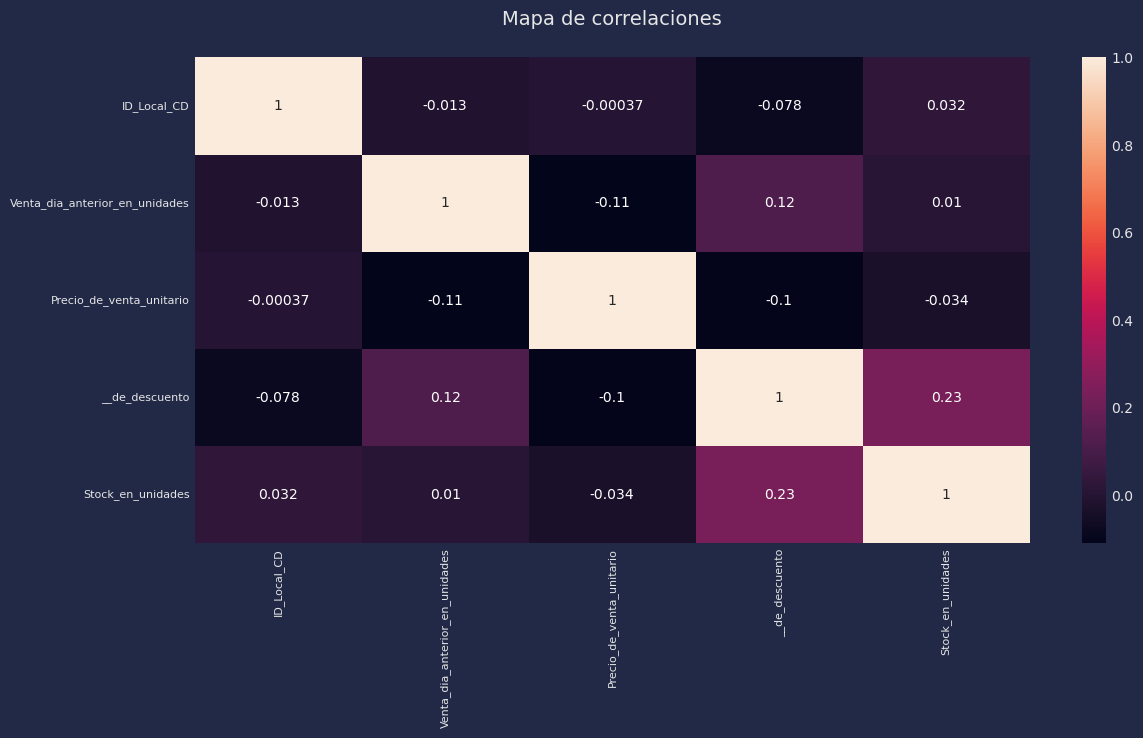

In [50]:

# Seleccionar las columnas de interés para el análisis de correlación
columns_of_interest = ['ID_Local_CD', 'Venta_dia_anterior_en_unidades',
'Precio_de_venta_unitario', '__de_descuento','Stock_en_unidades']

df1 = df[columns_of_interest]

# Normalizar el dataframe usando MinMaxScaler
scaler = MinMaxScaler()
df1_normalized = scaler.fit_transform(df1)
df1_normalized = pd.DataFrame(df1_normalized, columns=df1.columns)

# Calcular la matriz de correlación
corr_matrix = df1_normalized.corr()

# Graficar el mapa de calor de la correlación
fig, ax = plt.subplots(figsize=(12, 6))
heatmap =sns.heatmap(data=corr_matrix, annot=True, annot_kws={"fontsize": 10})
heatmap.tick_params(axis='both', which='major', labelsize=8)

plt.title('Mapa de correlaciones', fontsize=14, y=1.05)
plt.show()

# Clusterizacion por zonas

In [ ]:


# assuming latitudes and longitudes are in separate columns
data = df[['Latitud__Y_', 'Longitud__X_']].values

# instantiate a StandardScaler object
scaler = StandardScaler()

# fit the scaler to the data and transform the data
scaled_data = scaler.fit_transform(data)

# Seleccionar las columnas de 'Latitud__Y_' y 'Longitud__X_' como características
X = df[['Latitud__Y_', 'Longitud__X_']].values

# Imputar los valores faltantes con la mediana
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Aplicar el algoritmo de KMeans con 3 clústeres
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Create scatter plot with color-coded clusters
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(df['Longitud__X_'], df['Latitud__Y_'], c=df['cluster'])
plt.title('Geographical Point Clustering', fontsize=14, y=1.05)
plt.xlabel('Longitud__X_')
plt.ylabel('Latitud__Y_')
plt.xlim(df['Longitud__X_'].min() - 0.1, df['Longitud__X_'].max() + 0.1)
plt.ylim(df['Latitud__Y_'].min() - 0.1, df['Latitud__Y_'].max() + 0.1)
plt.show()

cluster_counts = df['cluster'].value_counts()
print(cluster_counts)

centroids = kmeans.cluster_centers_
print("Cluster centroids:", centroids)

In [ ]:
#2
# Generar el gráfico de caja para las ventas por clúster
fig, ax = plt.subplots(figsize=(12, 6))
fig,axes=plt.subplots()
colors = ['blue', 'green', 'orange', 'purple']
sns.scatterplot(data=df, x='cluster', y='Venta_dia_anterior_en_unidades', palette=colors, hue='cluster',alpha=0.6)
axes.set_xticklabels([' ', '0', ' ' ,'1', ' ', '2', '', '3'])
# Establecer etiqueta del eje x
plt.xlabel('Clúster', fontsize=10)
plt.ylabel('Ventas', fontsize=10)
plt.title('Clusterizacion por zonas segun ventas diarias', fontsize=14, y=1.05)
# Mostrar el grafio
plt.show()

In [ ]:
#3
# Define the two pairs of variables to compare
pair1 = ('Venta_dia_anterior_en_unidades', 'Precio_de_venta_unitario')
pair2 = ('Venta_dia_anterior_en_unidades', '__de_descuento')

# Loop over each cluster
for i in range(4):
    # Subset the data for the current cluster
    cluster_data = df[df['cluster'] == i]
    
    # Calculate the correlation matrix for the current cluster
    corr_matrix = cluster_data.corr()
    
    # Get the correlation coefficients for the two pairs of variables
    corr1 = corr_matrix.loc[pair1[0], pair1[1]]
    corr2 = corr_matrix.loc[pair2[0], pair2[1]]
    
    # Print the results
    print(f'Correlations for cluster {i}:')
    print(f'{pair1[0]}-{pair1[1]}: {corr1:.2f}')
    print(f'{pair2[0]}-{pair2[1]}: {corr2:.2f}')
    
        
    # Save the current correlation coefficients for the next iteration
    prev_corr1 = corr1
    prev_corr2 = corr2
    
    print('\n')
    